In [70]:
import pandahouse
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [98]:
connection = {
    'host': '_',
    'password': '_',
    'user': '_',
    'database': '_'
}


q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-04-24' and '2022-04-30'
    and exp_group in (2,1)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

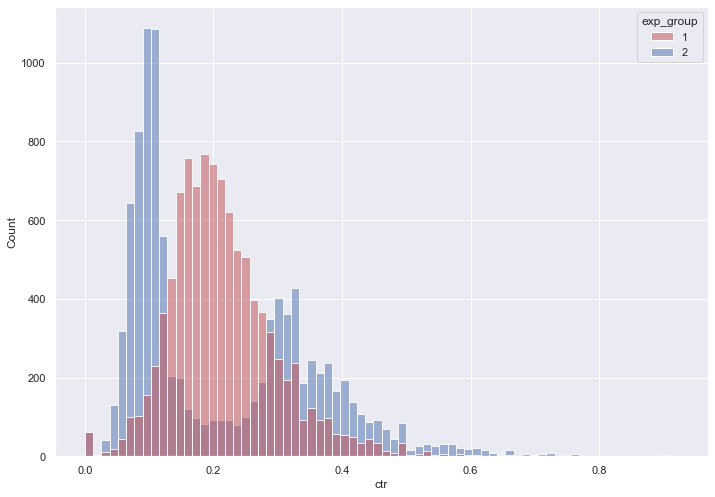

In [72]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

# T-тест

In [73]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

T-тест работает корректно только на нормальном распределении

# Тест Манна-Уитни

In [99]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

Отличия значимые

# Т-тест на сглаженном CTR

In [75]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [76]:
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

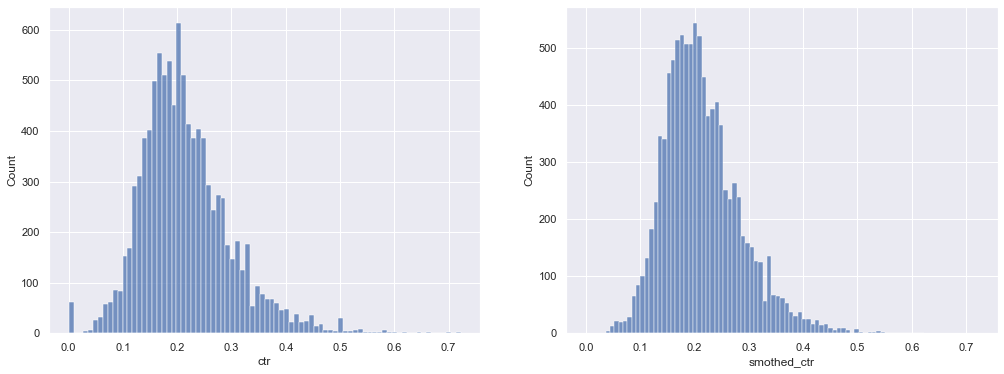

In [94]:
#Группа 1
figure, axes = plt.subplots(1, 2, sharex=True, figsize=(17,6))

group1 = df[df.exp_group == 1].copy()
sns.histplot(ax = axes[0], x = group1.ctr, 
             kde = False)

group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

sns.histplot(ax = axes[1], x = group1.smothed_ctr, 
             kde = False);

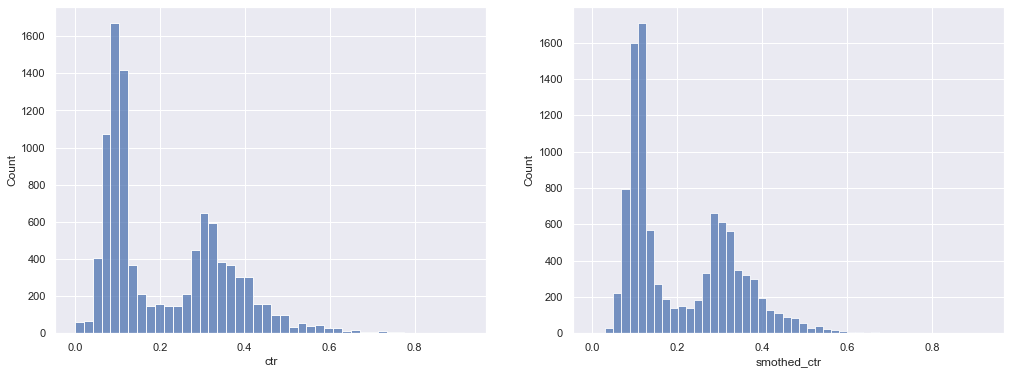

In [78]:
# Группа 2
figure, axes = plt.subplots(1, 2, sharex=True, figsize=(17,6))

group2 = df[df.exp_group == 2].copy()
sns.histplot(ax = axes[0], x = group2.ctr, 
             kde = False)

group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

sns.histplot(ax = axes[1], x = group2.smothed_ctr, 
             kde = False);

In [79]:
stats.ttest_ind(group1.smothed_ctr,
                group2.smothed_ctr,
                equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

На сглаженном CTR Т-тест видит существенные различия

# Бутстреп

In [80]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [101]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2, palette = ['r'])

<AxesSubplot:ylabel='Count'>

In [82]:
sns.histplot(ctr2 - ctr1)

<AxesSubplot:ylabel='Count'>

Во второй группе глобальный CTR ниже, чем в контрольной группе

# Баскетное преобразование(Т-тест и Манн-Уитни)

In [83]:
que = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-04-24' and '2022-04-30'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_2 = pandahouse.read_clickhouse(que, connection=connection)



In [103]:
sns.histplot(data = df_2, 
              x='bucket_ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False);

In [95]:
#тест Манна-Уитни
stats.mannwhitneyu(df_2[df_2.exp_group == 1].bucket_ctr, 
                   df_2[df_2.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

In [96]:
#t-тест
stats.ttest_ind(df_2[df_2.exp_group == 1].bucket_ctr, 
                   df_2[df_2.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

Оба теста видят существенные различия